# 16 - Correlation-heatmap

This notebook creates a correlation analysis for processed HQSL data.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Notebook config

In [2]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'
# save to local?
save_local = True
# use local data?
local_data = True
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution
res = 10
# Area of analysis
area_of_analysis = 'zona_censal' # zona_censal, hexagonos, unidades_vecinales
# Persona speed
walk_speed = 4.5
speed_name = str(walk_speed).replace('.','_')

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [5]:
if area_of_analysis == 'zona_censal' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_zonascensalesanalysis_{speed_name}_kmh.geojson')

elif area_of_analysis == 'zona_censal' and not local_data:
    table = f'santiago_zonascensalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'unidades_vecinales' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_unidadesvecinales_hqsl_{speed_name}_kmh.gpkg')

elif area_of_analysis == 'unidades_vecinales' and not local_data:
    table = f'santiago_unidadesvecinalesanalysis_{speed_name}_kmh'
    schema = 'projects_research'
    gdf = aup.gdf_from_db(table, schema)

elif area_of_analysis == 'hexagonos' and local_data:
    gdf = gpd.read_file(grl_dir + f'santiago_hexanalysis_res{res}_{speed_name}_kmh.geojson')

elif area_of_analysis == 'hexagonos' and not local_data:
    query = f'SELECT * FROM {schema}.santiago_hexanalysis_{speed_name}_kmh_pub WHERE res = {res}'
    gdf = aup.gdf_from_query(query)

print(gdf.shape)
gdf.head(2)

(1639, 38)


,geocodigo,gse_dom,gse_prom,ismtpn,dens_pobha,GEOCODI,prc_hg_,prc_cn_,prc_dmy,pr_JHES,...,wellbeing_working,wellbeing,supplying,caring,living,enjoying,learning,working,hqsl,geometry
0,13101011001,C1,C2,0.769388,103.946703,13101011001,0.763760,0.107536,0.133785,0.799323,...,5.196116,42.738248,7.581116,6.336907,5.599436,9.128404,4.462990,6.738089,39.846943,"POLYGON ((-70.64101 -33.43757, -70.64103 -33.4..."
1,13101011002,C1,C2,0.750089,226.888923,13101011002,0.827209,0.100078,0.076622,0.802971,...,5.074883,42.941134,8.236338,5.876095,6.304201,8.877243,4.428038,6.741553,40.463468,"POLYGON ((-70.64645 -33.43683, -70.64718 -33.4..."


## Load data

### Load data - processed HQSL data from chosen database (Notebook config)

<AxesSubplot: >

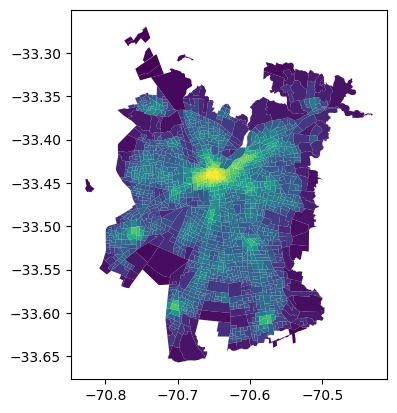

In [6]:
gdf.plot('hqsl')

## Columns of interest

In [7]:
# Social function count columns
social_fn_cols = []

for k in parameters_dict.keys():
    social_fn_cols.append(k+'_count')

# Summary columns
summary_cols = social_fn_cols[:]
if 'hqsl' not in summary_cols:
    summary_cols.append('hqsl')

cols_of_interest = ['hex_id','res','geometry']+summary_cols

# Show
print(social_fn_cols)
print(summary_cols)
print(cols_of_interest)

NameError: name 'parameters_dict' is not defined

In [10]:
col_analysis = ['ismtpn','dens_pobha','prc_hg_',
                  'prc_cn_','prc_dmy','pr_JHES','prc_OcA',
                  'sociability','wellbeing','environmental_impact',
                  'supplying','caring','living',
                  'enjoying','working','learning',
                  'hqsl']

## __Correlations__

### __Correlations__ - Social functions and HQSL Correlation

In [9]:
summary_cols

NameError: name 'summary_cols' is not defined

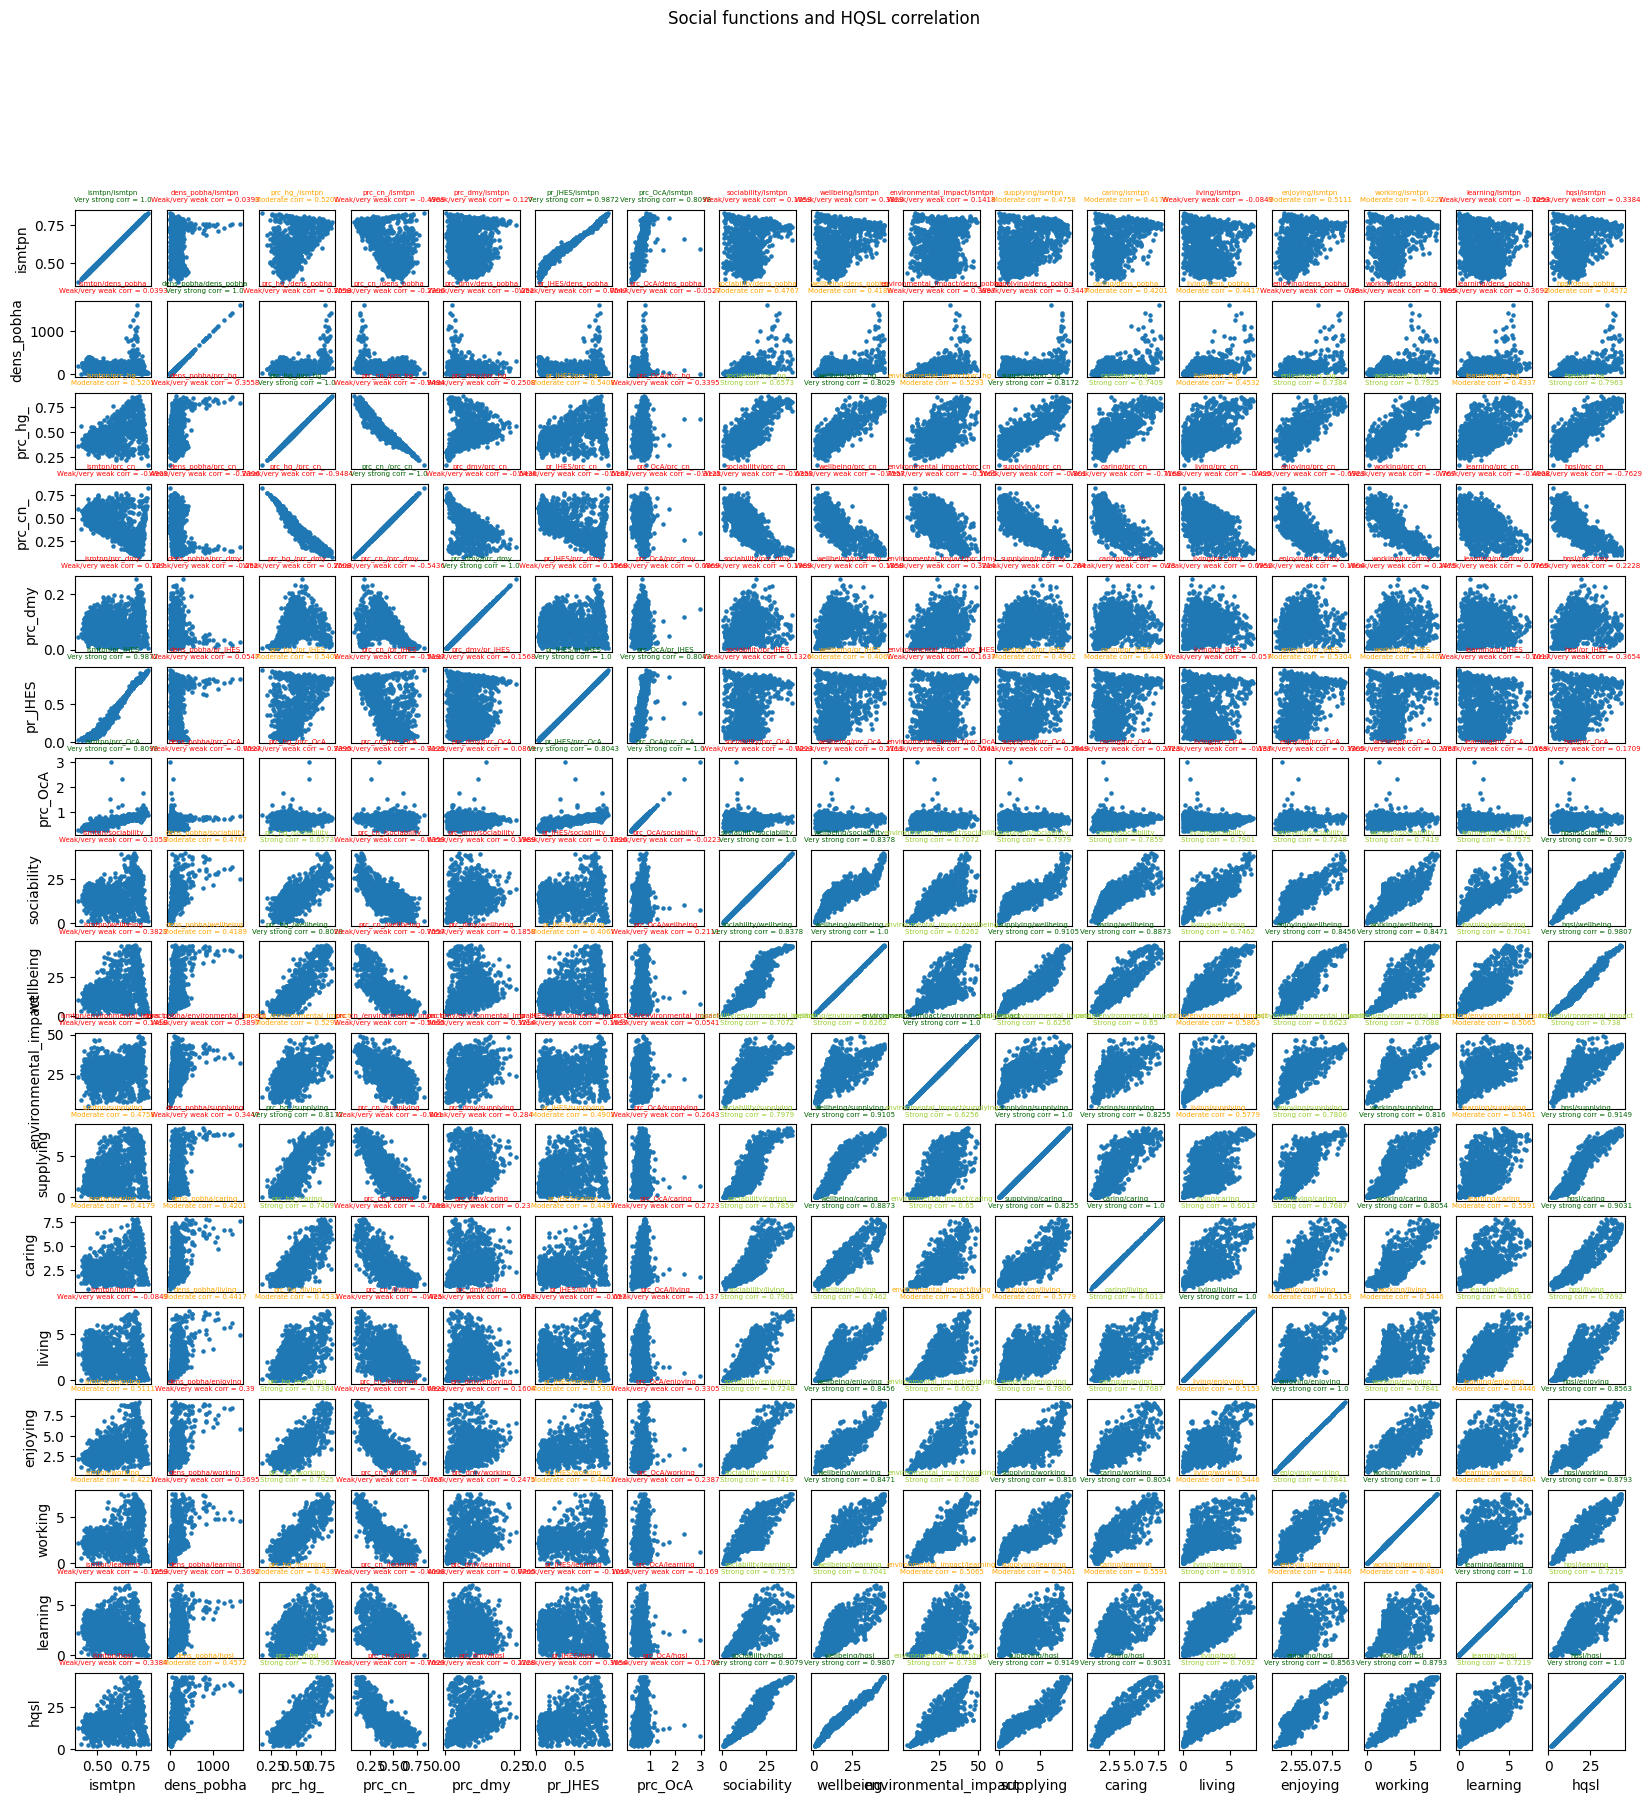

In [11]:
# Subplots grid with n by n combinations (6 social functions + HQSL = 7, 7x7)
summary_cols = col_analysis
data_gdf = gdf.dropna().copy()
fig, axs = plt.subplots(len(summary_cols), len(summary_cols), figsize=(20,20))
fig.suptitle('Social functions and HQSL correlation')

# For each col combination
for i in range(len(summary_cols)):
    
    # Sum correlations for current column
    summed_corr = 0
    
    for j in range(len(summary_cols)):
        
        #Plot scatter
        axs[i,j].scatter(data_gdf[summary_cols[j]], data_gdf[summary_cols[i]], s=5)

        #Correlation
        corr, pval = stats.pearsonr(data_gdf[summary_cols[j]],data_gdf[summary_cols[i]])
        summed_corr = summed_corr + corr

        # Correlation categories
        if corr > 0.80:
            corr_cat = 'Very strong'
            color='darkgreen'
        elif (corr<0.80) and (corr>0.60):
            corr_cat = 'Strong'
            color = 'yellowgreen'
        elif (corr<0.60) and (corr>0.40):
            corr_cat = 'Moderate'
            color = 'orange'
        else:
            corr_cat = 'Weak/very weak'
            color = 'red'

        # Set title with correlation categories and corr data
        axs[i,j].set_title(f"""{summary_cols[j].replace('_count','')}/{summary_cols[i].replace('_count','')}
{corr_cat} corr = {round(corr, 4)}""",fontsize=5,color=color)

        # Format - Turn off tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Format - Turn on last row/col tick marks and set used col label
        if i == len(summary_cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(summary_cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(summary_cols[i])

### __Correlations__ - Seaborn correlation heatmap

#### Create list of source columns of interest

In [12]:
# Collect all sources from parameters dict
all_sources = []
for sf in parameters_dict.keys():
    for th in parameters_dict[sf]:
        for source in parameters_dict[sf][th]:
            all_sources.append(source)

# Remove sources that do not have '_time' or _count_15min' cols (Not processed through regular proximity analysis)
all_sources.remove('viv_count')
all_sources.remove('viv_social_count')
all_sources.remove('hotel_count')
all_sources.remove('oficinas_count')
all_sources.remove('ndvi_count')

# Create time_cols list
time_cols = []
for source in all_sources:
    time_col = source+'_time'
    time_cols.append(time_col)

# Create count_cols list
count_cols=[]
for source in all_sources:
    count_col = source+'_count_15min'
    count_cols.append(count_col)

# Add sources that have '_count'
count_cols.append('viv_count')
count_cols.append('viv_social_count')
count_cols.append('hotel_count')
count_cols.append('oficinas_count')
count_cols.append('ndvi_count')

print("TIME COLUMNS:")
print(time_cols)
print("COUNT COLUMNS:")
print(count_cols)

TIME COLUMNS:
['carniceria_time', 'hogar_time', 'local_mini_market_time', 'bakeries_time', 'ferias_time', 'supermercado_time', 'centro_recyc_time', 'clinica_priv_time', 'clinica_pub_time', 'hospital_priv_time', 'hospital_pub_time', 'vacunatorio_priv_time', 'vacunatorio_pub_time', 'consult_ado_priv_time', 'consult_ado_pub_time', 'salud_mental_time', 'labs_priv_time', 'residencia_adumayor_time', 'farmacia_time', 'bomberos_time', 'club_deportivo_time', 'eq_deportivo_pub_time', 'eq_deportivo_priv_time', 'civic_office_time', 'tax_collection_time', 'social_security_time', 'correos_time', 'banco_time', 'police_time', 'ep_plaza_small_time', 'ep_plaza_big_time', 'museos_priv_time', 'museos_pub_time', 'bibliotecas_time', 'sitios_historicos_time', 'cines_time', 'librerias_time', 'restaurantes_bar_cafe_time', 'jardin_inf_pub_time', 'edu_especial_pub_time', 'edu_basica_pub_time', 'edu_media_pub_time', 'edu_tecnica_time', 'universidad_time', 'edu_adultos_pub_time', 'centro_edu_amb_time', 'ciclovias_

#### __Time__ columns correlation heatmap

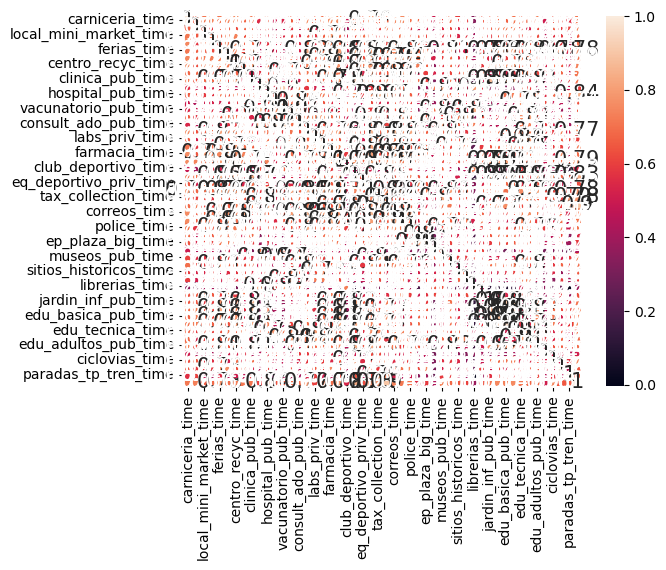

In [13]:
# Isolate data of interest
data_gdf_time = data_gdf[time_cols].copy()
# Create correlation heatmap
sns.heatmap(data_gdf_time.corr(), annot =True, annot_kws={"fontsize":15} )
# Seaborn plot format
sns.set(rc = {'figure.figsize':(50,50)})
# Show
plt.show()

In [14]:
# Asked Chat-gpt to extract 10 top correlations. Result:

# Step 1: Compute the Correlation Matrix
corr_matrix = data_gdf_time.corr()

# Step 2: Unstack the Matrix
corr_unstacked = corr_matrix.unstack()

# Step 3: Remove Self-Correlations
# Create a DataFrame from the unstacked series
corr_df = pd.DataFrame(corr_unstacked, columns=['Correlation']).reset_index()
corr_df.columns = ['Variable1', 'Variable2', 'Correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable1'] != corr_df['Variable2']]

# Step 4: Sort and Extract the Top 10 Correlations
# Take the absolute value of correlations for ranking
corr_df['AbsCorrelation'] = corr_df['Correlation'].abs()

# Sort by absolute correlation values in descending order
corr_df = corr_df.sort_values(by='AbsCorrelation', ascending=False)

# Drop duplicates (e.g., (A, B) and (B, A) are considered the same correlation)
time_corr_df = corr_df.drop_duplicates(subset=['AbsCorrelation'])

# Show
print("TOP TIME CORRELATIONS")
time_corr_df.head(15)

TOP TIME CORRELATIONS


,Variable1,Variable2,Correlation,AbsCorrelation
2041,edu_basica_pub_time,edu_media_pub_time,0.956430,0.956430
712,consult_ado_pub_time,vacunatorio_pub_time,0.913229,0.913229
2038,edu_basica_pub_time,jardin_inf_pub_time,0.903318,0.903318
609,vacunatorio_pub_time,hospital_priv_time,0.901369,0.901369
2475,paradas_tp_metro_time,social_security_time,0.899304,0.899304
2088,edu_media_pub_time,jardin_inf_pub_time,0.889017,0.889017
1971,edu_especial_pub_time,eq_deportivo_pub_time,0.888196,0.888196
524,hospital_pub_time,tax_collection_time,0.877658,0.877658
2039,edu_basica_pub_time,edu_especial_pub_time,0.872225,0.872225
438,clinica_pub_time,jardin_inf_pub_time,0.871272,0.871272


In [15]:
# Show
print("BOTTOM TIME CORRELATIONS")
time_corr_df.tail(5)

BOTTOM TIME CORRELATIONS


,Variable1,Variable2,Correlation,AbsCorrelation
1048,club_deportivo_time,paradas_tp_tren_time,0.132682,0.132682
1936,jardin_inf_pub_time,librerias_time,0.122163,0.122163
1839,librerias_time,edu_especial_pub_time,0.114961,0.114961
1840,librerias_time,edu_basica_pub_time,0.091243,0.091243
2436,paradas_tp_tren_time,librerias_time,-0.003270,0.003270


In [16]:
time_corr_df[['Correlation','AbsCorrelation']].describe()

,Correlation,AbsCorrelation
count,1225.000000,1225.000000
mean,0.605457,0.605463
std,0.134385,0.134361
min,-0.003270,0.003270
25%,0.527463,0.527463
50%,0.616012,0.616012
75%,0.699341,0.699341
max,0.956430,0.956430


In [17]:
if local_save:
    if hexs_database:
        if pub:
            time_corr_df.to_csv(save_dir+f'timecorrelations_{str_walking_speed}_pub_res{res}.csv')
        else:
            time_corr_df.to_csv(save_dir+f'timecorrelations_{str_walking_speed}_res{res}.csv')
    else:
        time_corr_df.to_csv(save_dir+f'timecorrelations_{save_code_name}.csv')

#### __Count__ columns correlation heatmap

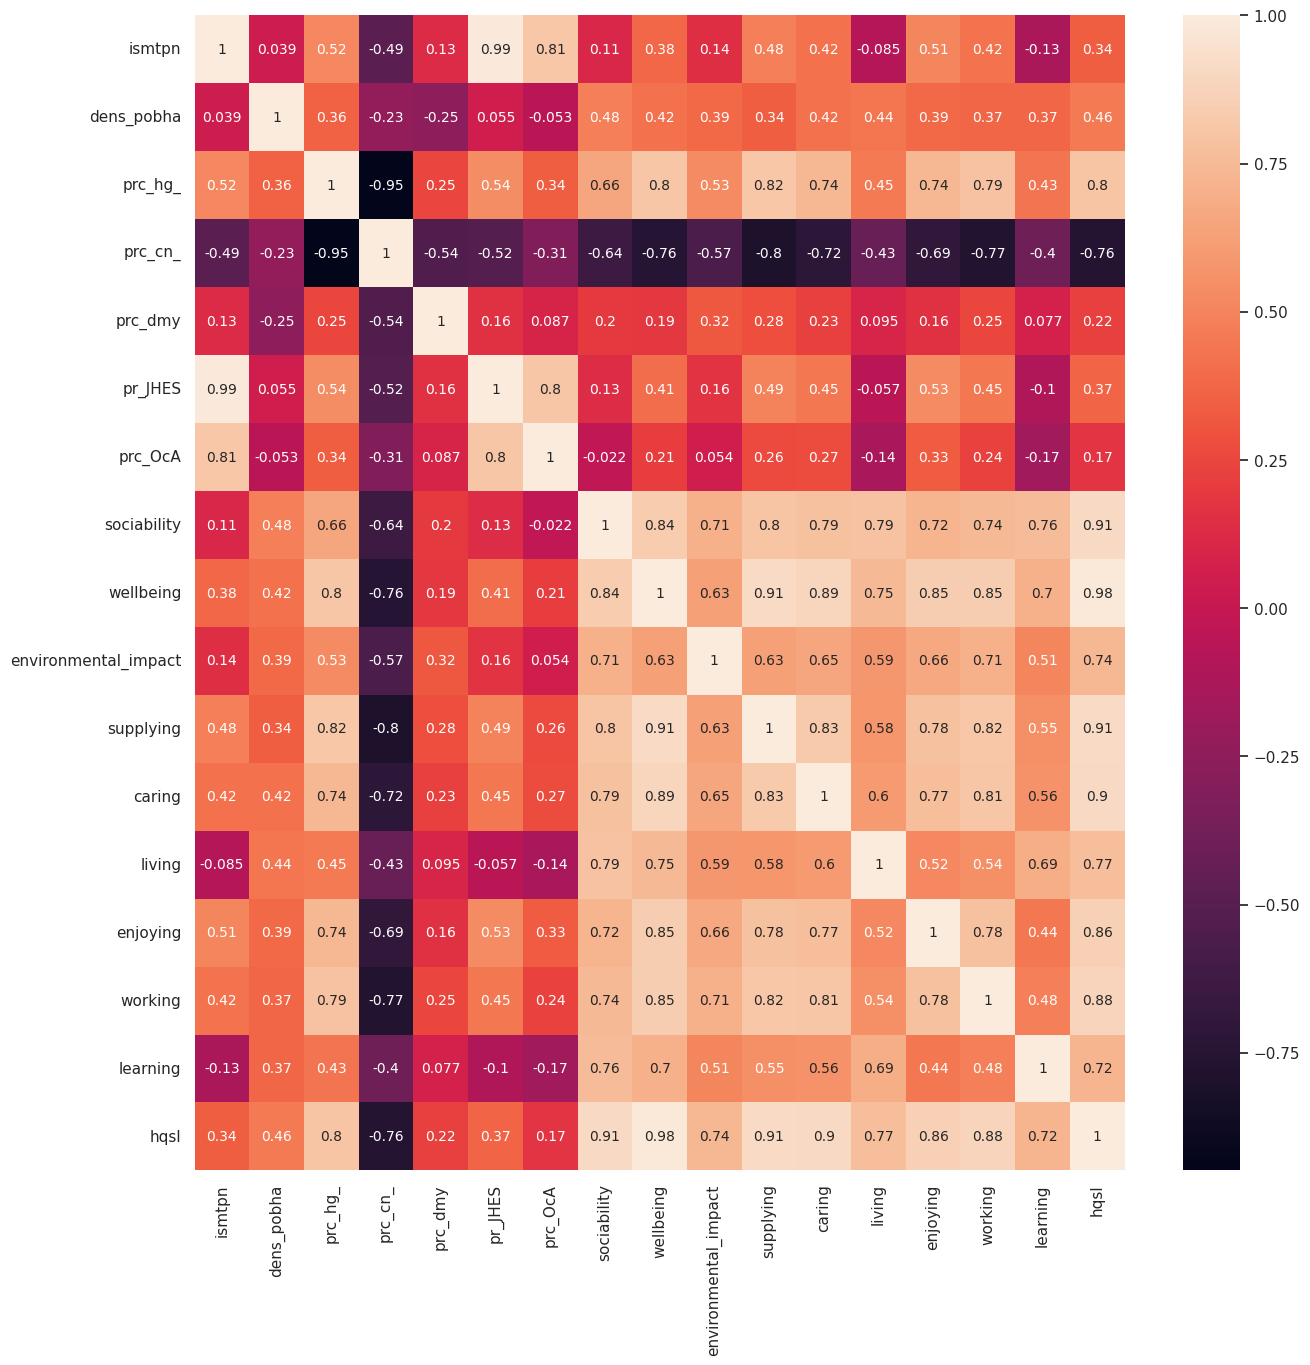

In [13]:
# Isolate data of interest
data_gdf_count = data_gdf[col_analysis].copy()
# Seaborn plot format
sns.set(rc = {'figure.figsize':(15,15)})
# Create correlation heatmap
sns.heatmap(data_gdf_count.corr(), annot =True, annot_kws={"fontsize":10} )

# Show
plt.savefig(f'../../../output/figures/santiago/polar_plots/{speed_name}/Correlation_Analysis.svg')

plt.show()


In [18]:
# Asked Chat-gpt to extract 10 top correlations. Result:

# Step 1: Compute the Correlation Matrix
corr_matrix = data_gdf_count.corr()

# Step 2: Unstack the Matrix
corr_unstacked = corr_matrix.unstack()

# Step 3: Remove Self-Correlations
# Create a DataFrame from the unstacked series
corr_df = pd.DataFrame(corr_unstacked, columns=['Correlation']).reset_index()
corr_df.columns = ['Variable1', 'Variable2', 'Correlation']

# Remove self-correlations
corr_df = corr_df[corr_df['Variable1'] != corr_df['Variable2']]

# Step 4: Sort and Extract the Top 10 Correlations
# Take the absolute value of correlations for ranking
corr_df['AbsCorrelation'] = corr_df['Correlation'].abs()

# Sort by absolute correlation values in descending order
corr_df = corr_df.sort_values(by='AbsCorrelation', ascending=False)

# Drop duplicates (e.g., (A, B) and (B, A) are considered the same correlation)
count_corr_df = corr_df.drop_duplicates(subset=['AbsCorrelation'])

# Show
print("TOP COUNT CORRELATIONS")
count_corr_df.head(50)

TOP COUNT CORRELATIONS


,Variable1,Variable2,Correlation,AbsCorrelation
85,pr_JHES,ismtpn,0.987190,0.987190
152,wellbeing,hqsl,0.981516,0.981516
37,prc_hg_,prc_cn_,-0.948435,0.948435
282,hqsl,supplying,0.915122,0.915122
146,wellbeing,supplying,0.910236,0.910236
135,sociability,hqsl,0.901473,0.901473
203,caring,hqsl,0.882526,0.882526
254,working,hqsl,0.878863,0.878863
195,caring,wellbeing,0.867469,0.867469
246,working,wellbeing,0.846924,0.846924


In [19]:
# Show
print("BOTTOM COUNT CORRELATIONS")
count_corr_df.tail(50)

BOTTOM COUNT CORRELATIONS


,Variable1,Variable2,Correlation,AbsCorrelation
258,learning,prc_cn_,-0.400833,0.400833
188,caring,dens_pobha,0.395921,0.395921
26,dens_pobha,environmental_impact,0.391641,0.391641
8,ismtpn,wellbeing,0.383888,0.383888
31,dens_pobha,working,0.372804,0.372804
277,hqsl,pr_JHES,0.371510,0.371510
256,learning,dens_pobha,0.369164,0.369164
30,dens_pobha,enjoying,0.369127,0.369127
35,prc_hg_,dens_pobha,0.355829,0.355829
171,supplying,dens_pobha,0.344811,0.344811


In [21]:
count_corr_df[['Correlation','AbsCorrelation']].describe()

,Correlation,AbsCorrelation
count,1485.000000,1485.000000
mean,0.255440,0.275152
std,0.234807,0.211349
min,-0.495487,0.000098
25%,0.065911,0.081128
50%,0.239731,0.246816
75%,0.414142,0.417817
max,0.927099,0.927099


In [22]:
if local_save:
    if hexs_database:
        if pub:
            count_corr_df.to_csv(save_dir+f'countcorrelations_{str_walking_speed}_pub_res{res}.csv')
        else:
            count_corr_df.to_csv(save_dir+f'countcorrelations_{str_walking_speed}_res{res}.csv')
    else:
        count_corr_df.to_csv(save_dir+f'countcorrelations_{save_code_name}.csv')

## Alameda Buffer

In [15]:
alameda = gpd.read_file(grl_dir + 'zonas_censales_buffer800m_alameda.gpkg')
print(alameda.shape)
alameda.head(2)

(127, 2)


,geocodigo,geometry
0,13101011001,"MULTIPOLYGON (((-70.63925 -33.43663, -70.63932..."
1,13101011002,"MULTIPOLYGON (((-70.64645 -33.43683, -70.64718..."


In [16]:
gdf = gdf.loc[gdf.geocodigo.isin(alameda.geocodigo)].copy()
print(gdf.shape)
gdf.head(2)

(127, 38)


,geocodigo,gse_dom,gse_prom,ismtpn,dens_pobha,GEOCODI,prc_hg_,prc_cn_,prc_dmy,pr_JHES,...,wellbeing_working,wellbeing,supplying,caring,living,enjoying,learning,working,hqsl,geometry
0,13101011001,C1,C2,0.769388,103.946703,13101011001,0.763760,0.107536,0.133785,0.799323,...,5.196116,42.738248,7.581116,6.336907,5.599436,9.128404,4.462990,6.738089,39.846943,"POLYGON ((-70.64101 -33.43757, -70.64103 -33.4..."
1,13101011002,C1,C2,0.750089,226.888923,13101011002,0.827209,0.100078,0.076622,0.802971,...,5.074883,42.941134,8.236338,5.876095,6.304201,8.877243,4.428038,6.741553,40.463468,"POLYGON ((-70.64645 -33.43683, -70.64718 -33.4..."


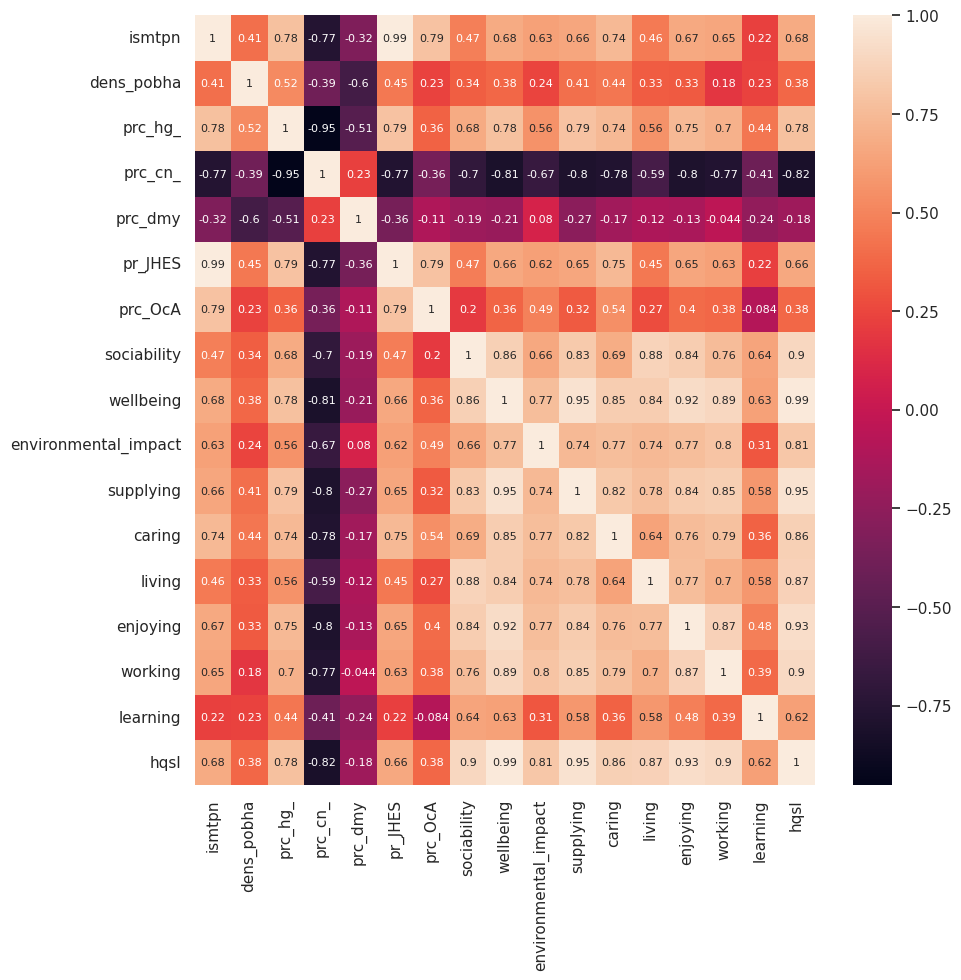

In [17]:
# Isolate data of interest
data_gdf_count = gdf[col_analysis].copy()
# Seaborn plot format
sns.set(rc = {'figure.figsize':(10,10)})
# Create correlation heatmap
sns.heatmap(data_gdf_count.corr(), annot =True, annot_kws={"fontsize":8} )

# Show
plt.savefig(f'../../../output/figures/santiago/polar_plots/{speed_name}/Correlation_Analysis.svg')

plt.show()


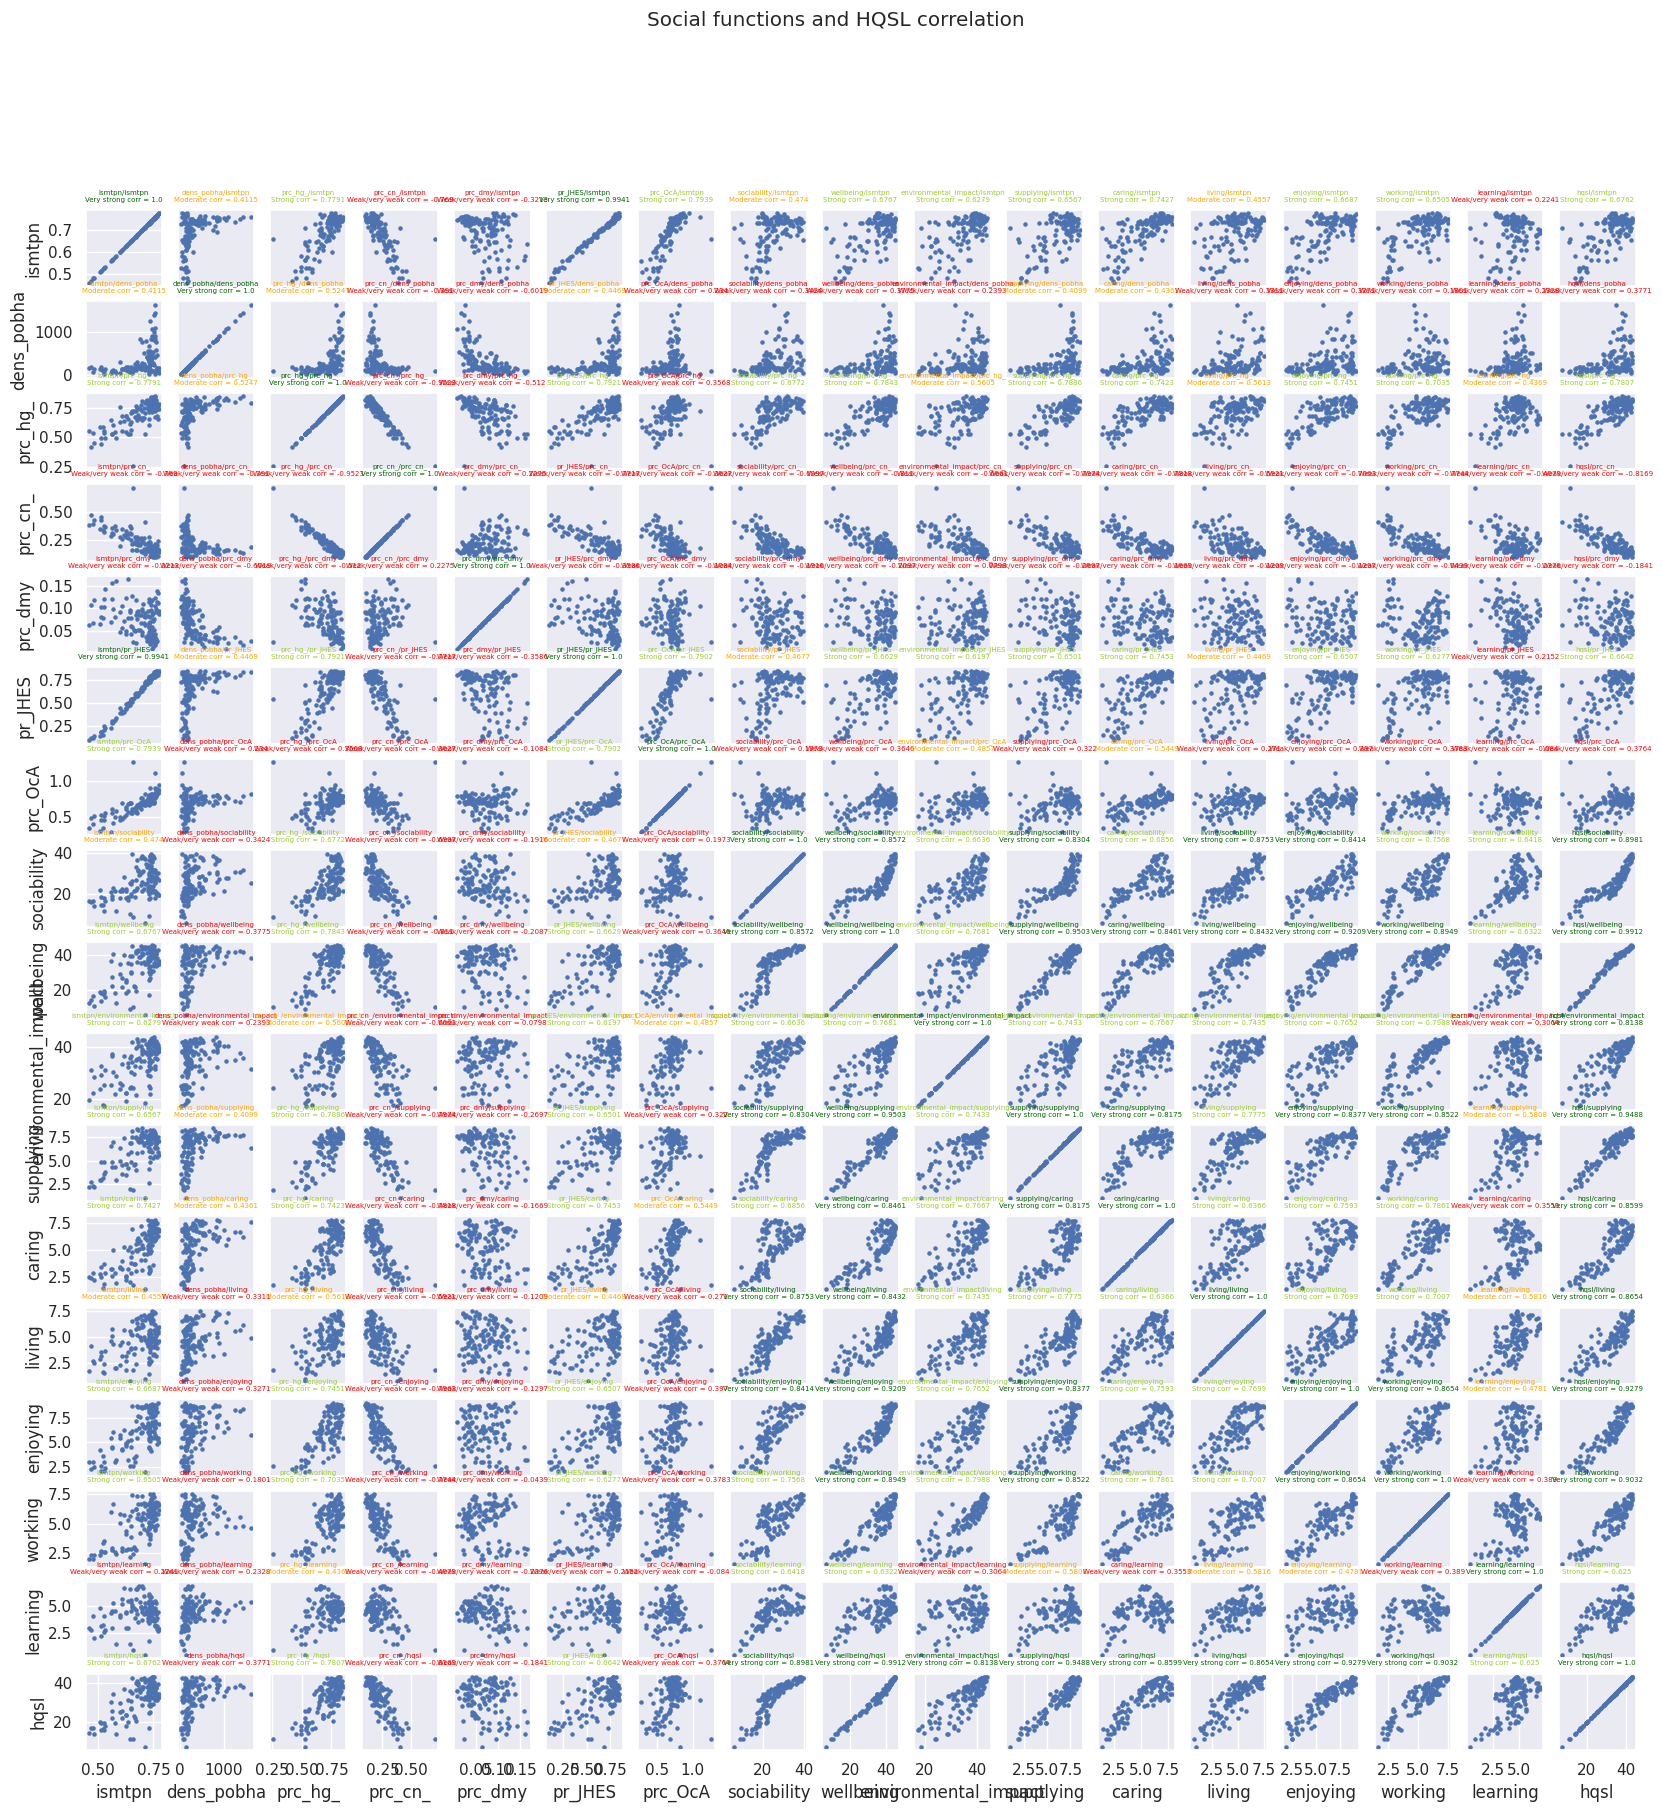

In [18]:
# Subplots grid with n by n combinations (6 social functions + HQSL = 7, 7x7)
summary_cols = col_analysis
data_gdf = gdf.dropna().copy()
fig, axs = plt.subplots(len(summary_cols), len(summary_cols), figsize=(20,20))
fig.suptitle('Social functions and HQSL correlation')

# For each col combination
for i in range(len(summary_cols)):
    
    # Sum correlations for current column
    summed_corr = 0
    
    for j in range(len(summary_cols)):
        
        #Plot scatter
        axs[i,j].scatter(data_gdf[summary_cols[j]], data_gdf[summary_cols[i]], s=5)

        #Correlation
        corr, pval = stats.pearsonr(data_gdf[summary_cols[j]],data_gdf[summary_cols[i]])
        summed_corr = summed_corr + corr

        # Correlation categories
        if corr > 0.80:
            corr_cat = 'Very strong'
            color='darkgreen'
        elif (corr<0.80) and (corr>0.60):
            corr_cat = 'Strong'
            color = 'yellowgreen'
        elif (corr<0.60) and (corr>0.40):
            corr_cat = 'Moderate'
            color = 'orange'
        else:
            corr_cat = 'Weak/very weak'
            color = 'red'

        # Set title with correlation categories and corr data
        axs[i,j].set_title(f"""{summary_cols[j].replace('_count','')}/{summary_cols[i].replace('_count','')}
{corr_cat} corr = {round(corr, 4)}""",fontsize=5,color=color)

        # Format - Turn off tick marks
        axs[i,j].get_xaxis().set_visible(False)
        axs[i,j].get_yaxis().set_visible(False)

        # Format - Turn on last row/col tick marks and set used col label
        if i == len(summary_cols) - 1:
            axs[i,j].get_xaxis().set_visible(True)
            axs[i,j].set_xlabel(summary_cols[j])

        if j == 0:
            axs[i,j].get_yaxis().set_visible(True)
            axs[i,j].set_ylabel(summary_cols[i])